# Auditing Vision Models using Language

Artificial intelligence, especially computer vision techniques, is becoming more pervasively used in various social contexts. As a result, it is important to understand its failure and bias. However, diagnosing and rectifying a vision model is intrinsically hard, because visual data are hard to collect. In this notebook, we will explore how to audit a vision model using language, given the flexibility and interpretability of language.

We will use the [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset to train a vision model that classifies whether a person wears lipstick. Because women often wear lipstick and men seldom wear lipstick, the vision model will have strong gender bias: it will use gender as spurious evidence to decide whether a person wears lipstick, therefore failing on two subsets of data (men with lipstick and women without lipstick).

We will show how we can use the language to diagnose the vision model and further rectify it in the above scenario. We show three applications: how we can use language to find error slices (i.e., subsets of data sharing common characteristics), identify influential attributes, and improve model performance on these slices.

## Download software and sampled CelebA dataset

First, we install our code base and download a processed version of the CelebA dataset. We randomly sampled 5,000 images from the original CelebA dataset because the original dataset is very large.

In [ ]:
# Download our software and install dependencies
!git clone https://github.com/yuhui-zh15/model_audit.git
!cd model_audit
!pip install -r requirements.txt

# Download the CelebA dataset and unzip it
!wget http://cs.stanford.edu/~yuhuiz/assets/manuscripts/celeba_sampled.zip > /dev/null
!unzip celeba_sampled.zip > /dev/null

In [1]:
from typing import Optional
import json
import random
import os
from collections import defaultdict

from tqdm import tqdm, trange
import clip
from clip.model import CLIP
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

from datasets import ImageDataset, TextDataset, create_dataloader
from trainer import extract_features
from models import Linear

base_path = "./celeba_sampled"

## Load CelebA dataset and extract features

We load the dataset and set the correct image path and its label (whether the person wears lipstick).

In [2]:
data = [json.loads(line) for line in open(f"{base_path}/attributes.jsonl")]
for item in data:
    item["image"] = f"{base_path}/{item['image']}"
    item["label"] = 1 if item["attributes"]["Wearing_Lipstick"] == 1 else 0

image_labels = torch.tensor([item["label"] for item in data])
train_idxs = [
    i for i, item in enumerate(data) if item["attributes"]["split"] == "train"
]
val_idxs = [i for i, item in enumerate(data) if item["attributes"]["split"] == "val"]

Let's take a look at four images that including two genders and two lipstick labels, and the statistics of the dataset.

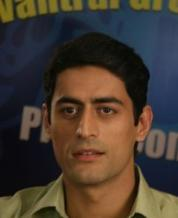

Man without lipstick.


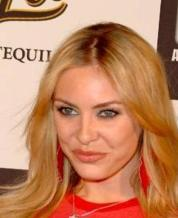

Woman with lipstick.


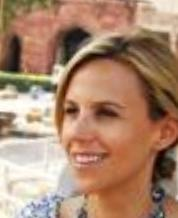

Woman without lipstick.


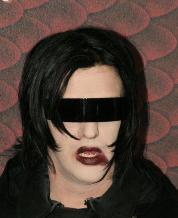

Man with lipstick.

Statistics of the dataset: {'Man without lipstick.': 2059, 'Woman with lipstick.': 2370, 'Woman without lipstick.': 560, 'Man with lipstick.': 11}


In [3]:
# Let's take a look at four images that including two genders and two lipstick labels.
showed_images = set()
counts = defaultdict(int)
for item in data:
    image = Image.open(item["image"])
    gender = "Man" if item["attributes"]["Male"] == 1 else "Woman"
    lipstick = (
        "with lipstick"
        if item["attributes"]["Wearing_Lipstick"] == 1
        else "without lipstick"
    )
    counts[f"{gender} {lipstick}."] += 1
    if (gender, lipstick) in showed_images:
        continue
    display(image)
    print(f"{gender} {lipstick}.")
    showed_images.add((gender, lipstick))

print()
print("Statistics of the dataset:", dict(counts))

## Extract image features from the dataset

Our vision model is built on CLIP, a multi-modal constative model that encodes rich features from images and text. We extract the image features from the dataset using CLIP.

In [4]:
model_name = "ViT-B/32"
clip_model, transform = clip.load(name=model_name, device="cuda")
clip_model = clip_model.float()

image_dataset = ImageDataset(data)
image_dataloader = create_dataloader(
    dataset=image_dataset,
    modality="image",
    transform=transform,
    shuffle=False,
    batch_size=1024,
    num_workers=16,
)
image_features = extract_features(
    dataloader=image_dataloader,
    clip_model=clip_model,
    modality="image",
    verbose=True,
)

Extracting features for image: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


## Train visual classifier on the extracted features

We train a visual classifier on the extracted features. After training, we can see the accuracy of the task is very high.

In [5]:
def train_one_epoch(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cuda",
):
    model.train()
    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def evaluate(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    device: str = "cuda",
) -> dict:
    model.eval()
    losses, preds, labels = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits, y)

            preds.extend(logits.argmax(-1).cpu().tolist())
            labels.extend(y.cpu().tolist())
            losses.append(loss.item())
    preds_np, labels_np = np.array(preds), np.array(labels)
    acc = np.mean(preds_np == labels_np)
    mean_loss = np.mean(losses)
    return {
        "acc": acc,
        "loss": mean_loss,
        "preds": preds_np,
        "labels": labels_np,
    }


def train_image_model(
    features: torch.Tensor,
    labels: torch.Tensor,
    train_idxs: list,
    val_idxs: list,
    n_epochs: int = 25,
    batch_size: int = 32,
    lr: float = 1e-3,
) -> torch.nn.Module:
    assert len(features) == len(
        labels
    ), "Features and labels should have the same length."
    features = F.normalize(features)

    train_features = features[train_idxs]
    train_labels = labels[train_idxs]
    val_features = features[val_idxs]
    val_labels = labels[val_idxs]

    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    d_model = features.shape[1]
    n_classes = int(labels.max().item() + 1)
    model = Linear(d_model, n_classes).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch_idx in range(n_epochs):
        train_one_epoch(train_dataloader, model, opt)
        metrics_train = evaluate(train_dataloader, model)
        metrics_val = evaluate(val_dataloader, model)
        print(
            f"Epoch {epoch_idx}: train_loss = {metrics_train['loss']:.4f}, train_acc = {metrics_train['acc']:.4f}, val_loss = {metrics_val['loss']:.4f}, val_acc = {metrics_val['acc']:.4f}"
        )

    return model


model = train_image_model(image_features, image_labels, train_idxs, val_idxs)
torch.save(model.state_dict(), "model.pt")

Epoch 0: train_loss = 0.5267, train_acc = 0.9143, val_loss = 0.5276, val_acc = 0.9160
Epoch 1: train_loss = 0.4246, train_acc = 0.9167, val_loss = 0.4263, val_acc = 0.9240
Epoch 2: train_loss = 0.3608, train_acc = 0.9177, val_loss = 0.3625, val_acc = 0.9260
Epoch 3: train_loss = 0.3187, train_acc = 0.9193, val_loss = 0.3199, val_acc = 0.9270
Epoch 4: train_loss = 0.2899, train_acc = 0.9205, val_loss = 0.2911, val_acc = 0.9260
Epoch 5: train_loss = 0.2691, train_acc = 0.9205, val_loss = 0.2701, val_acc = 0.9280
Epoch 6: train_loss = 0.2535, train_acc = 0.9207, val_loss = 0.2544, val_acc = 0.9260
Epoch 7: train_loss = 0.2416, train_acc = 0.9215, val_loss = 0.2424, val_acc = 0.9270
Epoch 8: train_loss = 0.2319, train_acc = 0.9225, val_loss = 0.2327, val_acc = 0.9270
Epoch 9: train_loss = 0.2241, train_acc = 0.9230, val_loss = 0.2251, val_acc = 0.9260
Epoch 10: train_loss = 0.2178, train_acc = 0.9235, val_loss = 0.2189, val_acc = 0.9280
Epoch 11: train_loss = 0.2122, train_acc = 0.9237, va

## Diagnose the visual classifier using the language

While the overall accuracy of the visual classifier is very high, we show that we find two critical errors in the model using language and can further rectify them.

### Discovering error slices

Now following our method, we feed the text to the trained vision model for diagnosis. Here we generate 4 text inputs and feed them into the model to see model behaviors: 

    "a man with lipstick.",
    "a man without lipstick.",
    "a woman with lipstick.",
    "a woman without lipstick.",

In [6]:
def evaluate_language(
    text_input: str,
    clip_model: CLIP,
    model: torch.nn.Module,
    device: str = "cuda",
) -> dict:
    model.eval()

    tokenized_texts = clip.tokenize([text_input]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(tokenized_texts)
        text_logits = model(text_features)
        text_preds = text_logits.softmax(-1).cpu().squeeze(0).tolist()

    return text_preds


text_inputs = [
    "a man with lipstick.",
    "a man without lipstick.",
    "a woman with lipstick.",
    "a woman without lipstick.",
]  # Hint: you can try more here!

probs = []
for text_input in text_inputs:
    text_pred = evaluate_language(text_input, clip_model, model)
    print(
        f'When feeding the text "{text_input}" to the visual classifier, the probability of it being classified as "wearing lipstick" is {text_pred[1]:.4f}.'
    )
    probs.append(text_pred[1])

When feeding the text "a man with lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 0.0000.
When feeding the text "a man without lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 0.0000.
When feeding the text "a woman with lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 1.0000.
When feeding the text "a woman without lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 0.9981.


Oops! We see that model fails to classify "a man with lipstick." into "with lipstick" and fails to classify "a woman without lipstick" into "without lipstick". These could represent two typical errors of the model.

We can verify these errors by feeding real images representing "a man with lipstick" and "a woman without lipstick". We find substantially lower accuracy of the model in these two groups. 

In [7]:
def get_group_acc(test_idxs):
    test_features = image_features[test_idxs]
    test_labels = image_labels[test_idxs]
    test_dataset = TensorDataset(test_features, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    test_metrics = evaluate(test_dataloader, model)
    return test_metrics["acc"]


test_idxs = [
    i
    for i, item in enumerate(data)
    if item["attributes"]["Wearing_Lipstick"] == -1 and item["attributes"]["Male"] == -1
]
print("Overall accuracy:", get_group_acc([i for i, item in enumerate(data)]))
print(
    "Accuracy of man with lipstick:",
    get_group_acc(
        [
            i
            for i, item in enumerate(data)
            if item["attributes"]["Wearing_Lipstick"] == 1
            and item["attributes"]["Male"] == 1
        ]
    ),
)
print(
    "Accuracy of woman without lipstick:",
    get_group_acc(
        [
            i
            for i, item in enumerate(data)
            if item["attributes"]["Wearing_Lipstick"] == -1
            and item["attributes"]["Male"] == -1
        ]
    ),
)

Overall accuracy: 0.922
Accuracy of man with lipstick: 0.0
Accuracy of woman without lipstick: 0.3678571428571429


### Identifying influential attributes

We can identify the influence of gender on the label "with lipstick". When a woman is presented, the average probability change to this class is ~0.5, showing the strong gender bias of the model!

In [8]:
genders = ["woman", "person"]
lipsticks = ["with lipstick", "without lipstick"]

probs = []
for gender in genders:
    for lipstick in lipsticks:
        text_input = f"a {gender} {lipstick}."
        text_pred = evaluate_language(text_input, clip_model, model)
        print(
            f'When feeding the text "{text_input}" to the visual classifier, the probability of it being classified as "wearing lipstick" is {text_pred[1]:.4f}.'
        )
        probs.append(text_pred[1])

print(
    f'The influence of "woman" to "lipstick" = {((probs[0] - probs[2]) + (probs[1] - probs[3])) / 2}'
)

When feeding the text "a woman with lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 1.0000.
When feeding the text "a woman without lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 0.9981.
When feeding the text "a person with lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 0.9232.
When feeding the text "a person without lipstick." to the visual classifier, the probability of it being classified as "wearing lipstick" is 0.1151.
The influence of "woman" to "lipstick" = 0.47989069670438766


## Rectify the visual classifier using the language

Now we use language to find two critical error slices of the model ("man with lipstick" and "woman without lipstick"), and understand the model has a strong gender bias for the final prediction. 

Here we use language to fix these problems by continue training the vision model on text inputs.

In [9]:
def train_one_epoch(
    dataloader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cuda",
):
    model.train()
    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


text_inputs = [
    "a man with lipstick.",
    "a man without lipstick.",
    "a woman with lipstick.",
    "a woman without lipstick.",
]
text_labels = torch.tensor([1, 0, 1, 0])
tokenized_texts = clip.tokenize(text_inputs).to("cuda")
with torch.no_grad():
    text_features = clip_model.encode_text(tokenized_texts)
text_dataset = TensorDataset(text_features, text_labels)
text_dataloader = DataLoader(text_dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in trange(1000):
    train_one_epoch(text_dataloader, model, optimizer)

100%|██████████| 1000/1000 [00:00<00:00, 1330.65it/s]


This simple method significantly improves the model performance on these two error slices, and does not hurt overall performance. 

In [10]:
def get_group_acc(test_idxs):
    test_features = image_features[test_idxs]
    test_labels = image_labels[test_idxs]
    test_dataset = TensorDataset(test_features, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    test_metrics = evaluate(test_dataloader, model)
    return test_metrics["acc"]


test_idxs = [
    i
    for i, item in enumerate(data)
    if item["attributes"]["Wearing_Lipstick"] == -1 and item["attributes"]["Male"] == -1
]
print("Overall accuracy:", get_group_acc([i for i, item in enumerate(data)]))
print(
    "Accuracy of man with lipstick:",
    get_group_acc(
        [
            i
            for i, item in enumerate(data)
            if item["attributes"]["Wearing_Lipstick"] == 1
            and item["attributes"]["Male"] == 1
        ]
    ),
)
print(
    "Accuracy of woman without lipstick:",
    get_group_acc(
        [
            i
            for i, item in enumerate(data)
            if item["attributes"]["Wearing_Lipstick"] == -1
            and item["attributes"]["Male"] == -1
        ]
    ),
)

Overall accuracy: 0.9276
Accuracy of man with lipstick: 0.18181818181818182
Accuracy of woman without lipstick: 0.4607142857142857


In summary, our research shows that language can be used to diagnose and rectify vision models.

For more details, please read our paper at https://openreview.net/pdf?id=D-zfUK7BR6c !